### Importando a base de dados

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from joblib import dump

from src.config import DADOS_TRATADOS, DADOS_TRATADOS_CLUSTER, MODELO_CLUSTER

sns.set_theme(palette="tab10")

RANDOM_STATE = 1

base = pd.read_parquet(DADOS_TRATADOS)

base.head()

,age,gender,bmi,children,discount_eligibility,region,expenses,premium
0,19,female,24.1,0,yes,south,1483.208344,1744.950993
1,18,male,23.5,1,no,southeast,2237.607934,2632.479922
2,28,male,33.0,3,no,southeast,2046.087156,2728.116207
3,33,male,23.3,0,no,midwest,2331.692044,2743.167111
4,32,male,23.4,0,no,midwest,1942.501251,2285.295590


In [2]:
base.info()

<class 'pandas.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1332 non-null   int64  
 1   gender                1332 non-null   str    
 2   bmi                   1332 non-null   float64
 3   children              1332 non-null   int64  
 4   discount_eligibility  1332 non-null   str    
 5   region                1332 non-null   str    
 6   expenses              1332 non-null   float64
 7   premium               1332 non-null   float64
dtypes: float64(3), int64(2), str(3)
memory usage: 102.5 KB


In [3]:
base.nunique()

age                       47
gender                     2
bmi                      247
children                   6
discount_eligibility       2
region                     4
expenses                1332
premium                 1332
dtype: int64

### Avaliar quais variáveis fazem sentido para a clusterização

In [4]:
colunas_categoricas = ["gender","discount_eligibility","region"]
colunas_numericas = ["age","bmi","children"]
colunas_alvo = ["expenses","premium"]

colunas_cluster = colunas_categoricas + colunas_numericas

base_insurance_cluster = base[colunas_cluster]

base_insurance_cluster

,gender,discount_eligibility,region,age,bmi,children
0,female,yes,south,19,24.1,0
1,male,no,southeast,18,23.5,1
2,male,no,southeast,28,33.0,3
3,male,no,midwest,33,23.3,0
4,male,no,midwest,32,23.4,0
...,...,...,...,...,...,...
1327,male,no,midwest,50,31.0,3
1328,female,no,northeast,18,23.5,0
1329,female,no,southeast,18,25.3,0
1330,female,no,south,21,23.9,0


### Definindo preprocessamento 

In [5]:
preprocessamento = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), colunas_categoricas),
    ("scaler", StandardScaler(), colunas_numericas),
])

In [6]:
preprocessamento

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('onehot', ...), ('scaler', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. 

### Estudo PCA

In [7]:
estudo_pca = Pipeline([
    ("preprocessamento", preprocessamento),
    ("pca", PCA())
])

estudo_pca.fit(base_insurance_cluster)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessamento', ...), ('pca', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('onehot', ...), ('scaler', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfo

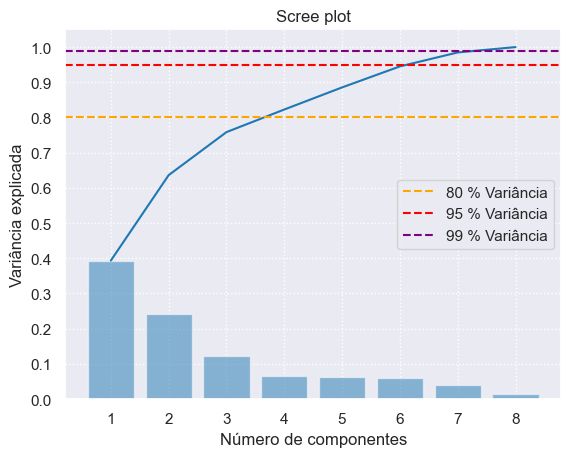

In [8]:
fig, ax = plt.subplots()

ax.plot(
    range(1, estudo_pca["pca"].n_components_ + 1),
    np.cumsum(estudo_pca["pca"].explained_variance_ratio_),
)

ax.axhline(y=0.80, color="orange", linestyle="--", label="80 % Variância")
ax.axhline(y=0.95, color="red", linestyle="--", label="95 % Variância")
ax.axhline(y=0.99, color="purple", linestyle="--", label="99 % Variância")

ax.bar(
    x=range(1, estudo_pca["pca"].n_components_ + 1),
    height=estudo_pca["pca"].explained_variance_ratio_,
    alpha=0.5
)

ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.grid(linestyle=":")

ax.set_xlabel("Número de componentes")
ax.set_ylabel("Variância explicada")
ax.set_title("Scree plot")

ax.legend()

plt.show()

### Análise dos Componentes
 - Nota-se que 3 componentes explicam 75% da variação dos dados
 - 2 componentes explicam cerca de 65% da varição dos dados

Seguiremos com 2 componentes para obter a visualização

### Estudo da quantidade de Clusters

c:\Users\User\anaconda3\envs\case_health_insurance\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\User\anaconda3\envs\case_health_insurance\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\User\anaconda3\envs\case_health_insurance\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\User\anaconda3\envs\case_health_insurance\Lib\sit

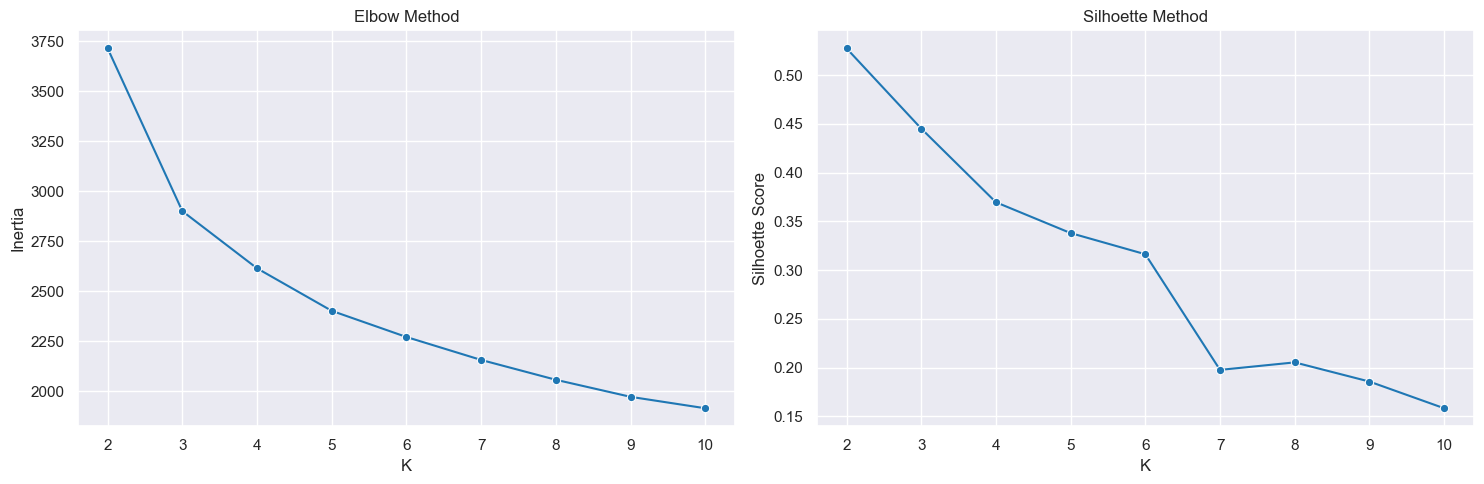

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5), tight_layout=True)


elbow = {}
silhouette = []
k_range = range(2,11)

X = base_insurance_cluster


for numero in k_range:
    kmeans = Pipeline([
        ("preprocessamento", preprocessamento),
        ("kmeans", KMeans(n_clusters=numero, random_state=RANDOM_STATE, n_init=10))
    ])
    kmeans.fit(X)

    elbow[numero] = kmeans["kmeans"].inertia_
    labels = kmeans["kmeans"].labels_

    silhouette.append(silhouette_score(kmeans.transform(X), labels))

sns.lineplot(x=list(elbow.keys()), y=list(elbow.values()), ax=axs[0], marker="o")
axs[0].set_xlabel("K")
axs[0].set_ylabel("Inertia")
axs[0].set_title("Elbow Method")

sns.lineplot(x=list(k_range), y=silhouette, ax=axs[1], marker="o")
axs[1].set_xlabel("K")
axs[1].set_ylabel("Silhoette Score")
axs[1].set_title("Silhoette Method")


plt.show()

Seguiremos com o número de 4 clusters para a segmentação

In [10]:
kmeans = Pipeline([
    ("preprocessamento", preprocessamento),
    ("pca", PCA(n_components=2)),
    ("kmeans", KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10))
])

kmeans.fit(X)

c:\Users\User\anaconda3\envs\case_health_insurance\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessamento', ...), ('pca', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('onehot', ...), ('scaler', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tr

In [11]:
kmeans["kmeans"].labels_

array([3, 3, 2, ..., 3, 3, 0], shape=(1332,), dtype=int32)

In [12]:
kmeans["kmeans"].cluster_centers_

array([[ 0.79846971, -1.01132437],
       [ 1.49862591,  0.72796049],
       [ 0.00799342,  1.39282299],
       [-1.34434321, -0.11223305]])

### Adicionando clusters na base

In [13]:
base_insurance_cluster["cluster"] = kmeans["kmeans"].labels_
base["cluster"] = kmeans["kmeans"].labels_


base_insurance_cluster.head()

,gender,discount_eligibility,region,age,bmi,children,cluster
0,female,yes,south,19,24.1,0,3
1,male,no,southeast,18,23.5,1,3
2,male,no,southeast,28,33.0,3,2
3,male,no,midwest,33,23.3,0,3
4,male,no,midwest,32,23.4,0,3


### Exportando dados com cluster

In [14]:
base.to_parquet(DADOS_TRATADOS_CLUSTER, index=False)

In [15]:
base_insurance_cluster.groupby("cluster").describe().T

cluster                  0           1           2           3
age      count  400.000000  228.000000  211.000000  493.000000
         mean    52.990000   47.135965   32.739336   27.006085
         std      7.203445    9.252880    9.381508    8.054563
         min     37.000000   23.000000   18.000000   18.000000
         25%     47.000000   41.000000   25.000000   20.000000
         50%     54.000000   48.000000   31.000000   25.000000
         75%     59.000000   54.000000   39.000000   33.000000
         max     64.000000   64.000000   54.000000   57.000000
bmi      count  400.000000  228.000000  211.000000  493.000000
         mean    31.684250   34.796053   26.746919   22.833671
         std      5.311616    4.994334    4.298486    1.822020
         min     18.300000   24.600000   18.300000   16.800000
         25%     27.600000   31.225000   23.700000   21.400000
         50%     31.600000   34.250000   25.800000   22.800000
         75%     35.925000   37.850000   29.750000   24.200000
         max     46.200000   46.800000   39.400000   26.300000
children count  400.000000  228.000000  211.000000  493.000000
         mean     0.355000    2.482456    2.682464    0.375254
         std      0.479113    0.717711    0.866644    0.509220
         min      0.000000    1.000000    2.000000    0.000000
         25%      0.000000    2.000000    2.000000    0.000000
         50%      0.000000    2.000000    2.000000    0.000000
         75%      1.000000    3.000000    3.000000    1.000000
         max      1.000000    5.000000    5.000000    2.000000

### Analisando distribuição dos dados

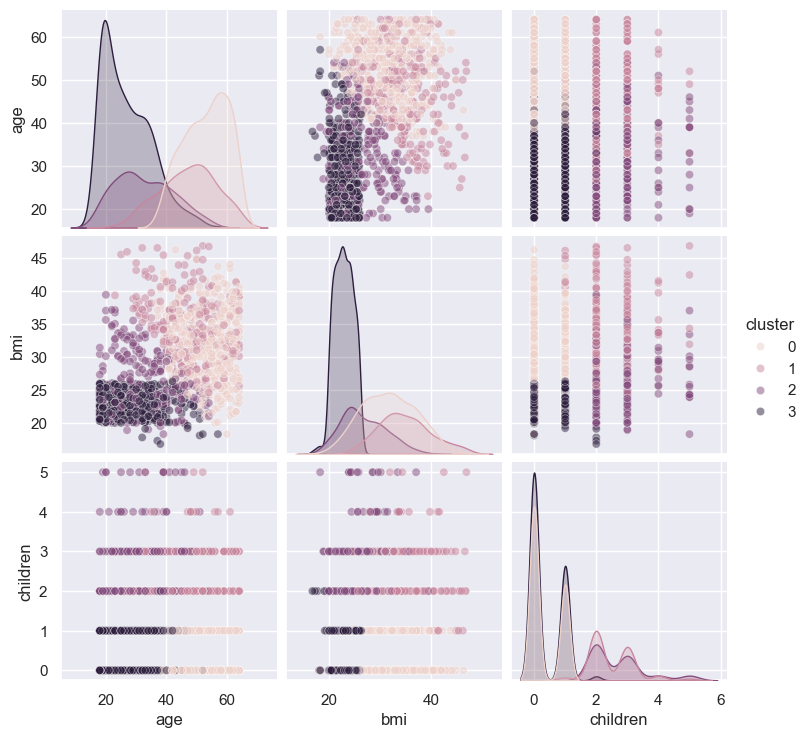

In [16]:
sns.pairplot(base_insurance_cluster, hue="cluster", plot_kws={"alpha":0.5})

### Visualizando a segmentação dos Clusters

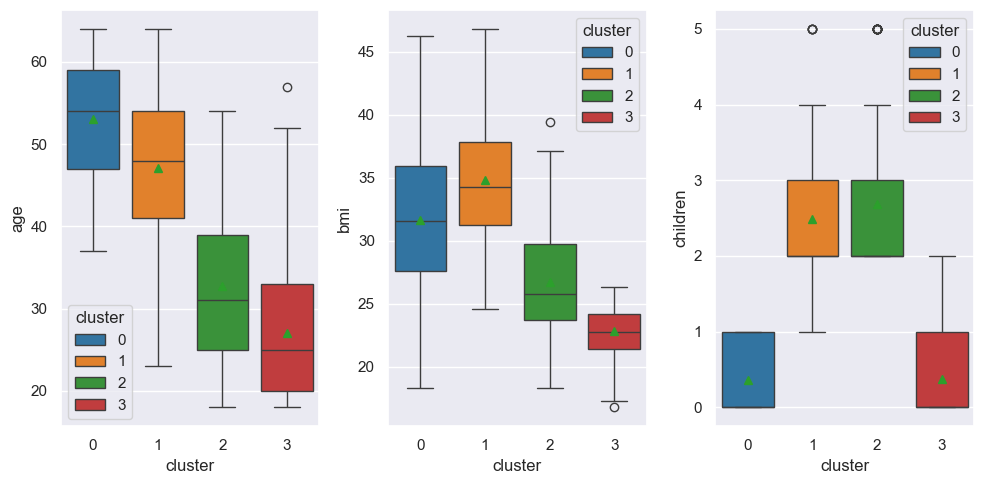

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

for ax, coluna in zip(axs.flatten(), base_insurance_cluster.select_dtypes("number")):
    sns.boxplot(
        base_insurance_cluster,
        ax=ax,
        x="cluster",
        y=coluna,
        palette="tab10",
        hue="cluster",
        showmeans=True
    )
plt.tight_layout()
plt.show()

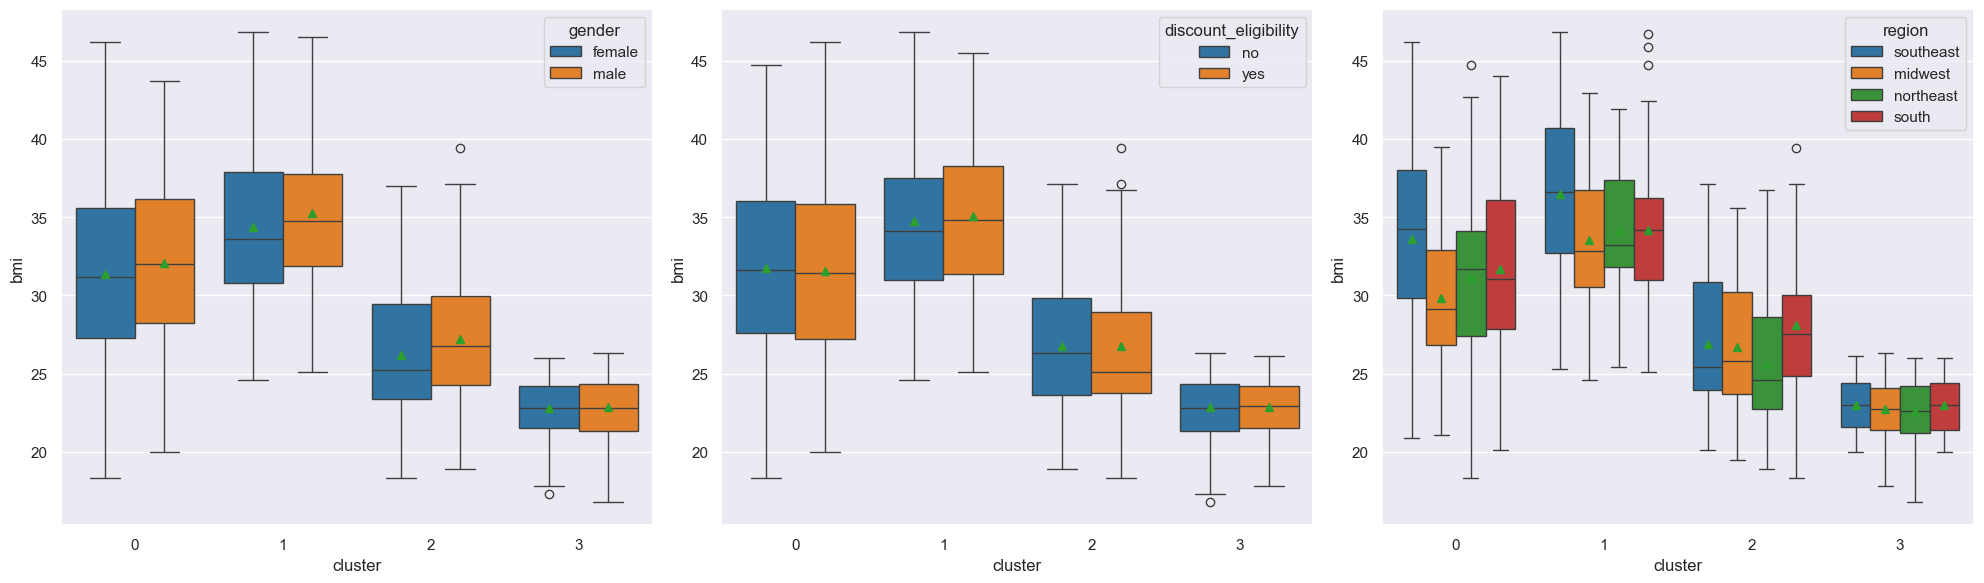

In [18]:


cluster_diff_cols = ["age","bmi","children"]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,6), tight_layout=True)

for ax, column in zip(axs.flatten(), colunas_categoricas):
    sns.boxplot(x="cluster", y=cluster_diff_cols[1], data=base_insurance_cluster, ax=ax, showmeans=True, palette="tab10", hue=column)

### Resumo da classificação dos clusters

- Cluster 0: Idade elevada, IMC médio/elevado, número de filhos baixo ou zero
- Cluster 1: Idade média para elevada, IMC médio, número de filhos médio
- Cluster 2: Idade baixa/média, IMC baixo/médio, número de filhos 2 ou mais
- Cluster 3: Idade baixa, IMC baixo, número de filhos máximo 2 filhos



In [19]:
df_pca = pd.DataFrame(
    kmeans[:-1].transform(X),
    columns=kmeans[:-1].get_feature_names_out()
)

df_pca.head()

,pca0,pca1
0,-1.669760,-0.140297
1,-1.467322,0.628937
2,0.613574,1.726187
3,-1.132090,-0.572316
4,-1.165628,-0.541798


In [20]:
centroids = kmeans["kmeans"].cluster_centers_

centroids

array([[ 0.79846971, -1.01132437],
       [ 1.49862591,  0.72796049],
       [ 0.00799342,  1.39282299],
       [-1.34434321, -0.11223305]])

## Visualização dos Clusters

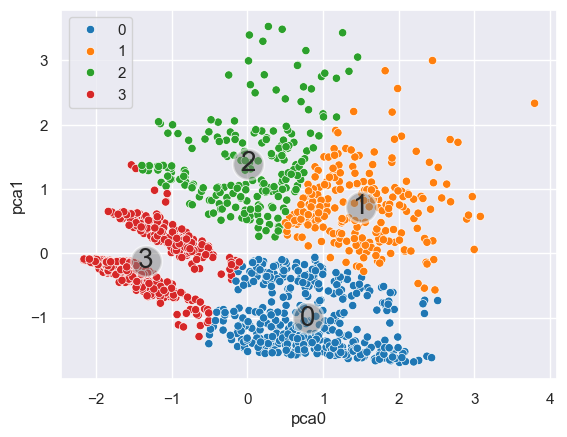

In [21]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()

cores = plt.cm.tab10.colors[:4]
cores = ListedColormap(cores)

x, y = df_pca.columns

sns.scatterplot(
    x=x,
    y=y,
    data=df_pca,
    hue=base_insurance_cluster["cluster"],
    ax=ax,
    palette=cores
)

sns.scatterplot(
    x=centroids[:, 0],
    y=centroids[:,1],
    color="gray",
    marker="o",
    s=500,
    alpha=0.5,
)

ax.text(centroids[0,0], centroids[0,1], "0", fontsize=20, ha="center", va="center")
ax.text(centroids[1,0], centroids[1,1], "1", fontsize=20, ha="center", va="center")
ax.text(centroids[2,0], centroids[2,1], "2", fontsize=20, ha="center", va="center")
ax.text(centroids[3,0], centroids[3,1], "3", fontsize=20, ha="center", va="center")



plt.show()

In [22]:
kmeans["pca"].components_

array([[ 0.00483369, -0.00757397, -0.02285578,  0.01117758,  0.02546238,
         0.62804313,  0.69570343,  0.34667301],
       [ 0.01748679,  0.00971516, -0.01015889,  0.00777254, -0.00968758,
        -0.44004168, -0.04947885,  0.89624635]])

In [23]:
kmeans["preprocessamento"].get_feature_names_out()

array(['onehot__gender_male', 'onehot__discount_eligibility_yes',
       'onehot__region_northeast', 'onehot__region_south',
       'onehot__region_southeast', 'scaler__age', 'scaler__bmi',
       'scaler__children'], dtype=object)

### Classificação dos componentes e seus pesos na segmentação dos clusters

In [24]:
pd.DataFrame(
    data=kmeans["pca"].components_[0],
    index=kmeans["preprocessamento"].get_feature_names_out(),
    columns=["PC0"],
).sort_values(by="PC0", ascending=False)

,PC0
scaler__bmi,0.695703
scaler__age,0.628043
scaler__children,0.346673
onehot__region_southeast,0.025462
onehot__region_south,0.011178
onehot__gender_male,0.004834
onehot__discount_eligibility_yes,-0.007574
onehot__region_northeast,-0.022856


In [25]:
pd.DataFrame(
    data=kmeans["pca"].components_[1],
    index=kmeans["preprocessamento"].get_feature_names_out(),
    columns=["PC1"],
).sort_values(by="PC1", ascending=False)

,PC1
scaler__children,0.896246
onehot__gender_male,0.017487
onehot__discount_eligibility_yes,0.009715
onehot__region_south,0.007773
onehot__region_southeast,-0.009688
onehot__region_northeast,-0.010159
scaler__bmi,-0.049479
scaler__age,-0.440042


In [26]:
base_insurance_cluster.head()

,gender,discount_eligibility,region,age,bmi,children,cluster
0,female,yes,south,19,24.1,0,3
1,male,no,southeast,18,23.5,1,3
2,male,no,southeast,28,33.0,3,2
3,male,no,midwest,33,23.3,0,3
4,male,no,midwest,32,23.4,0,3


### Analisando a média dos dados

In [27]:
analise_base = base.groupby("cluster")[["age","bmi","children","expenses","premium"]].mean()

analise_base.head()

,age,bmi,children,expenses,premium
cluster,,,,,
0,52.990000,31.684250,0.355000,4745.711134,4520.832754
1,47.135965,34.796053,2.482456,2417.011044,3097.224284
2,32.739336,26.746919,2.682464,1854.353136,2405.512721
3,27.006085,22.833671,0.375254,1904.684633,2222.497265


### Adicionando regras de negócio aos dados

In [ ]:
desvpad = base.groupby("cluster")[["expenses"]].std()
coef_var = desvpad/base.groupby("cluster")[["expenses"]].mean()
lucro_medio = base.groupby("cluster")[["premium"]].mean().values - base.groupby("cluster")[["expenses"]].mean().values
margem_lucro = lucro_medio/base.groupby("cluster")[["premium"]].mean()
media_expenses = base.groupby("cluster")["expenses"].mean()
margem_desejada = pd.Series(
    [0.25, 0.25, 0.2, 0.25],
    index=analise_base.indexg
)

analise_base["desvpad"] = desvpad.map("{:.2f}".format)
analise_base["coef_var"] = coef_var.map("{:.2%}".format)
analise_base["lucro_medio"] = lucro_medio
analise_base["margem_lucro"] = margem_lucro.map("{:.2%}".format)
analise_base["margem_desejada"] = margem_desejada
analise_base["preco_alvo"] = (media_expenses/(1-margem_desejada))


analise_base.head()

,age,bmi,children,expenses,premium,desvpad,coef_var,lucro_medio,margem_lucro,margem_desejada,preco_alvo
cluster,,,,,,,,,,,
0,52.990000,31.684250,0.355000,4745.711134,4520.832754,690.79,14.56%,-224.878380,-4.97%,0.25,6327.614846
1,47.135965,34.796053,2.482456,2417.011044,3097.224284,914.75,37.85%,680.213240,21.96%,0.25,3222.681393
2,32.739336,26.746919,2.682464,1854.353136,2405.512721,546.30,29.46%,551.159585,22.91%,0.20,2317.941420
3,27.006085,22.833671,0.375254,1904.684633,2222.497265,491.56,25.81%,317.812632,14.30%,0.25,2539.579510


## Quanto cobrar

In [29]:
base["preco_alvo_cluster"] = base["cluster"].map(
    analise_base["preco_alvo"]
)

In [30]:
base.head(20)

,age,gender,bmi,children,discount_eligibility,region,expenses,premium,cluster,preco_alvo_cluster
0,19,female,24.1,0,yes,south,1483.208344,1744.950993,3,2539.579510
1,18,male,23.5,1,no,southeast,2237.607934,2632.479922,3,2539.579510
2,28,male,33.0,3,no,southeast,2046.087156,2728.116207,2,2317.941420
3,33,male,23.3,0,no,midwest,2331.692044,2743.167111,3,2539.579510
4,32,male,23.4,0,no,midwest,1942.501251,2285.295590,3,2539.579510
5,31,female,22.9,0,no,southeast,2375.740544,2794.988875,3,2539.579510
6,46,female,33.4,1,no,southeast,4453.233926,4241.175168,0,6327.614846
7,37,female,27.7,3,no,midwest,2326.688166,3102.250888,2,2317.941420
8,37,male,29.8,2,no,northeast,1712.425978,2283.234638,2,2317.941420
9,60,female,25.8,0,no,midwest,4684.820589,4461.733894,0,6327.614846


In [31]:
base["lucro_teriamos"] = base["preco_alvo_cluster"] -base["expenses"]
base["lucro_tivemos"] = base["premium"] -base["expenses"]


base.head()

,age,gender,bmi,children,discount_eligibility,region,expenses,premium,cluster,preco_alvo_cluster,lucro_teriamos,lucro_tivemos
0,19,female,24.1,0,yes,south,1483.208344,1744.950993,3,2539.57951,1056.371166,261.742649
1,18,male,23.5,1,no,southeast,2237.607934,2632.479922,3,2539.57951,301.971576,394.871988
2,28,male,33.0,3,no,southeast,2046.087156,2728.116207,2,2317.94142,271.854265,682.029052
3,33,male,23.3,0,no,midwest,2331.692044,2743.167111,3,2539.57951,207.887466,411.475067
4,32,male,23.4,0,no,midwest,1942.501251,2285.295590,3,2539.57951,597.078259,342.794338


### Resultado da aplicação da regra de negócio nos dados

In [32]:
lucro_antigo = base["lucro_tivemos"].sum()

lucro_novo = base["lucro_teriamos"].sum()


print(f"Lucro antigo: {lucro_antigo:,.2f}")
print(f"Lucro novo: {lucro_novo:,.2f}")




Lucro antigo: 338,113.57
Lucro novo: 1,227,274.63


### Exportando o modelo de Cluster

In [33]:
dump(kmeans, MODELO_CLUSTER)

['C:\\Users\\User\\Desktop\\GDrive\\Obsidian Vault\\Pós-Graduação - FNAT\\Modulo 1\\4  Case Health Insurance\\modelo_projeto_data_science\\modelos\\CLUSTER.joblib']